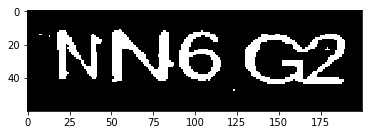

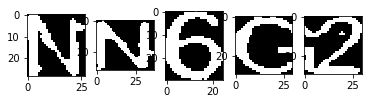

In [1]:
import os
import cv2
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
%matplotlib inline

def show_image(image):
    plt.imshow(image)
    plt.show()

def filter_small(arr, oriIdx, area):
    mList = list(filter(lambda x: x[1] < 20, arr))
    if mList != []:
        mList += [ (area,0,oriIdx) ]
        remain = max(mList)
        del mList[mList.index(remain)]
        return remain[2], [item[2] for item in mList]
    else:
        return oriIdx, []

def remove_near_contour(pos):
    idx = 0
    if len(pos) <= 5:
        return pos
    while idx < 5 and len(pos) > 5:
        x,y,w,h = pos[idx]
        other   = [ (pos[i][2] * pos[i][3],
                     abs(pos[i][0]-x) + abs(pos[i][1]-y),
                     i ) for i in range(idx+1,len(pos)) ]
        ridx, rm_idx = filter_small(other, idx, w*h)
        if rm_idx != []:
            pos[idx] = pos[ridx]
            for k in rm_idx:
                del pos[k]
        idx = idx + 1
    return pos
            

def truncate_length(pos):
    if len(pos) > 5:
        arr = sorted([(w*h,i) for i,(x,y,w,h) in enumerate(pos)], reverse=True)
        return [ pos[i] for i,(x,y,w,h) in enumerate(pos) if (w*h,i) in arr[:5] ]
    else:
        return pos

    
def filter_img_threshold(img, t1, t2, val):
    for i in range(len(img)):
        for idx, darr in enumerate(img[i]):
            img[i][idx] = [ val if t1<=v<=t2 else v for v in darr ]
    return img


def get_captcha_url_from_html(html_text, base_url):
    soup = BeautifulSoup(html_text, 'html.parser')
    for img in soup.find_all('img'):
        src = img.attrs.get(u'src', '')
        if src != '' and 'CaptchaImage.aspx' in src:
            return base_url + src
    return ''
        
class Crawler:
    def __init__(self, 
                 root_url = 'https://bsr.twse.com.tw/bshtm/', 
                 page_url = 'https://bsr.twse.com.tw/bshtm/bsMenu.aspx'):
        random.seed()
        self.root_url   = root_url
        self.page_url   = page_url
        self.header    = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}
        self.session   = requests.Session()
        self.content_text  = self.session.get(page_url, headers=self.header).text
    
    def get_captcha_image(self):
        url = get_captcha_url_from_html(self.content_text, self.root_url)
        raw_img  = self.session.get(url, stream=True, headers=self.header)
        fname    = str(random.randint(1048576,1073741824)) + '.jpg'
        with open(fname, 'wb') as out_file:
            shutil.copyfileobj(raw_img.raw, out_file)
        image = cv2.imread(fname)
        os.remove(fname)
        return image

    def split_image(self, src_img):
        target_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY);
        contours, _ = cv2.findContours(target_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnts = sorted([(c, cv2.boundingRect(c)[0]) for c in contours], key = lambda x: x[1])
        pos  = []
        for (c,_) in cnts:
            (x,y,w,h) = cv2.boundingRect(c)
            if w > 50 and h > 15:
                pos.append((x,y,w//2,h))
                pos.append((x+w//2,y,w//2,h))
            elif w * h > 280:
                pos.append((x,y,w,h))
        
        pos = remove_near_contour(pos)
        pos = truncate_length(pos)
        res = []
        for i, (x,y,w,h) in enumerate(pos):
            res.append(src_img[y:y + h, x:x + w])
        return res
        
    def crack_code(self):
        img     = self.get_captcha_image()
        kernel  = np.ones((2,2), np.uint8)
        erosion = cv2.erode(img, kernel, iterations = 2)
        blurred = cv2.GaussianBlur(erosion, (3,3), 5)
        res_img = np.array(blurred)
        res_img[(res_img >= 120)] = 255
        res_img[(res_img <= 120)] = 0
        return img, res_img

cr  = Crawler()
original_image, res_img = cr.crack_code()
splot_arr_imgs          = cr.split_image(res_img)

#print all results
show_image(res_img)
fig = plt.figure()
for idx, img in enumerate(splot_arr_imgs):
    a = fig.add_subplot(1,len(splot_arr_imgs),idx+1)
    plt.imshow(img)
plt.show()



